In [ ]:
import numpy as np
import pandas as pd
import random
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Generate and Save Synthetic Data to CSV
def generate_and_save_data(filename='synthetic_traffic_data.csv', samples=100000):
    data = []
    for _ in range(samples):
        time = np.random.randint(0, 24)
        time_sin = np.sin(2 * np.pi * time / 24)
        time_cos = np.cos(2 * np.pi * time / 24)
        if 7 <= time <= 10 or 17 <= time <= 20:
            traffic = np.random.randint(600, 1000)
        elif 11 <= time <= 16:
            traffic = np.random.randint(300, 600)
        else:
            traffic = np.random.randint(100, 300)
        max_capacity = 1000
        utilization = traffic / max_capacity
        congestion = min(100, utilization * 120 + np.random.normal(10, 5))
        speed = max(5, 80 - congestion * 0.6)
        vehicle = np.random.randint(0, 3)
        vehicle_one_hot = [0, 0, 0]
        vehicle_one_hot[vehicle] = 1
        action = 1 if congestion > 70 or utilization > 0.85 else 0
        row = [traffic, speed, congestion, utilization, time_sin, time_cos] + vehicle_one_hot + [action]
        data.append(row)

    columns = ['traffic', 'speed', 'congestion', 'utilization', 'time_sin', 'time_cos',
               'vehicle_0', 'vehicle_1', 'vehicle_2', 'action']
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Synthetic data saved to {filename}")
    return filename

# Step 2: Load and Preprocess Data
def load_and_preprocess(filename):
    df = pd.read_csv(filename)
    X = df.drop("action", axis=1).values
    y = df["action"].values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return train_test_split(X_scaled, y, test_size=0.2, random_state=42), scaler

# Step 3: Build DQN Model
def build_model(state_size):
    model = Sequential([
        Dense(32, input_dim=state_size, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(2, activation='linear')
    ])
    model.compile(optimizer=Adam(0.0003), loss='mse')
    return model

# Step 4: Define DQN Agent
class DQNAgent:
    def __init__(self, state_size):
        self.state_size = state_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 128
        self.model = build_model(state_size)
        self.target_model = build_model(state_size)
        self.update_target_model()

    def remember(self, s, a, r, ns):
        self.memory.append((s, a, r, ns))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randint(0, 1)
        q_values = self.model.predict(np.expand_dims(state, axis=0), verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([m[0] for m in minibatch])
        actions = np.array([m[1] for m in minibatch])
        rewards = np.array([m[2] for m in minibatch])
        next_states = np.array([m[3] for m in minibatch])

        target_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)

        for i in range(self.batch_size):
            target_q[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q[i])

        self.model.fit(states, target_q, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

# Step 5: Train Agent
def train_agent(X_train, y_train, episodes=300):
    agent = DQNAgent(X_train.shape[1])
    acc_hist, loss_hist = [], []

    for episode in range(episodes):
        total_correct = 0
        indices = np.random.randint(0, len(X_train), size=agent.batch_size)

        for i in indices:
            state = X_train[i]
            true_action = int(y_train[i])
            pred_action = agent.act(state)
            reward = 1 if pred_action == true_action else -1
            if pred_action == true_action:
                total_correct += 1
            agent.remember(state, pred_action, reward, state)

        agent.replay()

        accuracy = total_correct / agent.batch_size
        acc_hist.append(accuracy)

        # Create Q-values as labels based on rewards (as used in training)
        states = X_train[indices]
        q_values = agent.model.predict(states, verbose=0)
        next_q = agent.target_model.predict(states, verbose=0)

        for i, idx in enumerate(indices):
            true_action = int(y_train[idx])
            reward = 1 if np.argmax(q_values[i]) == true_action else -1
            q_values[i][true_action] = reward + agent.gamma * np.max(next_q[i])

        loss = agent.model.evaluate(states, q_values, verbose=0)
        loss_hist.append(loss)

        if episode % 50 == 0:
            agent.update_target_model()
            print(f"Episode {episode} - Epsilon: {agent.epsilon:.3f} - Accuracy: {accuracy:.4f}")

        if agent.epsilon < 0.1:
            print("Early stopping (low epsilon).")
            break

    agent.model.save("traffic_dqn_model.keras")
    print("Model saved as traffic_dqn_model.keras")
    return agent, acc_hist, loss_hist

# Step 6: Test Model and Save Predictions
def test_model(X_test, y_test):
    model = load_model("traffic_dqn_model.keras")
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    acc = accuracy_score(y_test, y_pred) * 100
    print(f"\nAccuracy: {acc:.2f}%")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Save predictions to CSV
    df_results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
    df_results.to_csv("prediction_results.csv", index=False)
    print("Predictions saved to prediction_results.csv")

    return y_pred

# Step 7: Run Full Pipeline
csv_file = generate_and_save_data()
(X_train, X_test, y_train, y_test), scaler = load_and_preprocess(csv_file)
agent, acc_hist, loss_hist = train_agent(X_train, y_train, episodes=500)
y_pred = test_model(X_test, y_test)


Synthetic data saved to synthetic_traffic_data.csv


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 0 - Epsilon: 0.995 - Accuracy: 0.5312
Episode 50 - Epsilon: 0.774 - Accuracy: 0.6328
Episode 100 - Epsilon: 0.603 - Accuracy: 0.6641
Episode 150 - Epsilon: 0.469 - Accuracy: 0.7891
Episode 200 - Epsilon: 0.365 - Accuracy: 0.7969
Episode 250 - Epsilon: 0.284 - Accuracy: 0.8750
Episode 300 - Epsilon: 0.221 - Accuracy: 0.8594
Episode 350 - Epsilon: 0.172 - Accuracy: 0.8750
Episode 400 - Epsilon: 0.134 - Accuracy: 0.8828
Episode 450 - Epsilon: 0.104 - Accuracy: 0.9453
Early stopping (low epsilon).
Model saved as traffic_dqn_model.keras

Accuracy: 98.69%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     11884
           1       0.99      0.97      0.98      8116

    accuracy                           0.99     20000
   macro avg       0.99      0.98      0.99     20000
weighted avg       0.99      0.99      0.99     20000

Predictions saved to prediction_results.csv


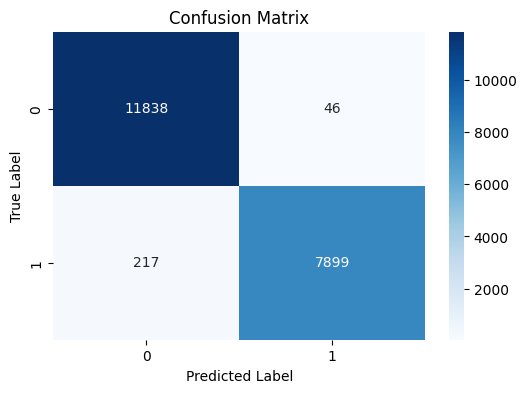

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure 'y_test' and 'y_pred' are available from the main code
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(y_test, y_pred, average=None)  # 'average=None' gives score for each class
for i, p in enumerate(precision):
    print(f"Precision for class {i}: {p:.2f}")


Precision for class 0: 0.98
Precision for class 1: 0.99


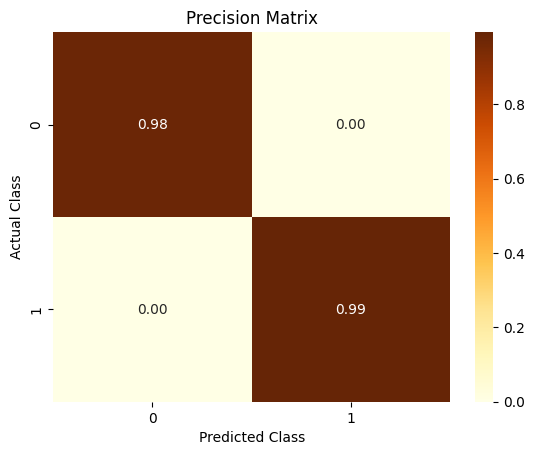

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert to 2D matrix if needed
precision_matrix = np.diag(precision)

sns.heatmap(precision_matrix, annot=True, cmap="YlOrBr", fmt=".2f")
plt.title("Precision Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()


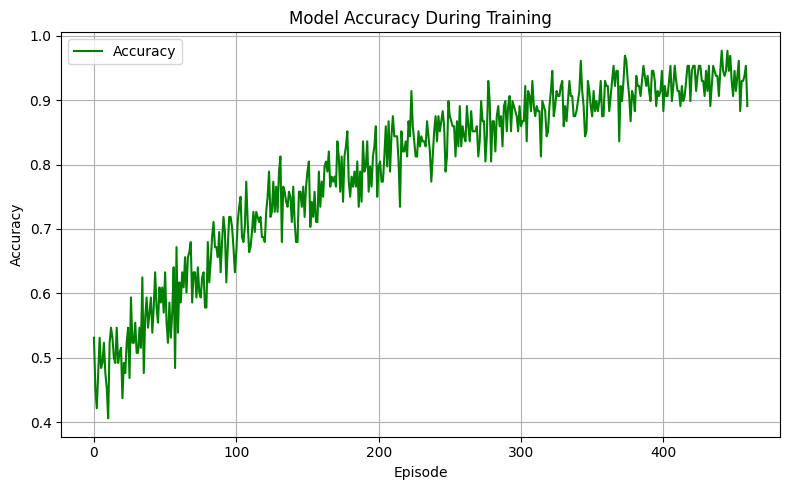

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(acc_hist, color='green', label='Accuracy')
plt.title('Model Accuracy During Training')
plt.xlabel('Episode')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


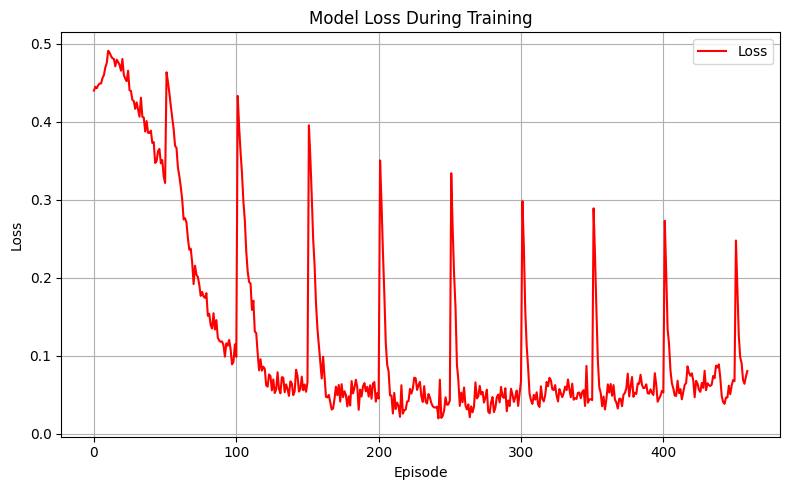

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_hist, color='red', label='Loss')
plt.title('Model Loss During Training')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


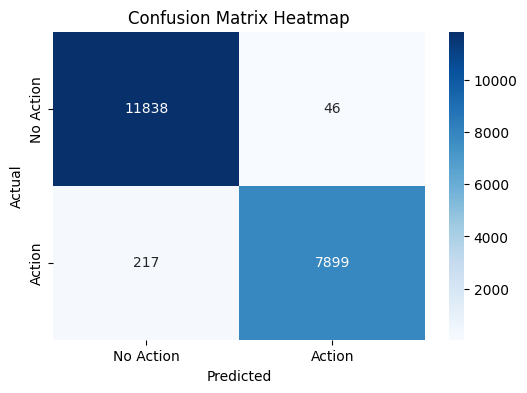

In [ ]:
# Step 8: Plot Confusion Matrix Heatmap
def plot_confusion_heatmap(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Action", "Action"], yticklabels=["No Action", "Action"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix Heatmap")
    plt.show()

# Call the function
plot_confusion_heatmap(y_test, y_pred)
